# LoRA

Low-Rank Adaptation of Large Language Models是一种在大模型中高效微调的方法。只训练极少数参数让模型适应新任务 \
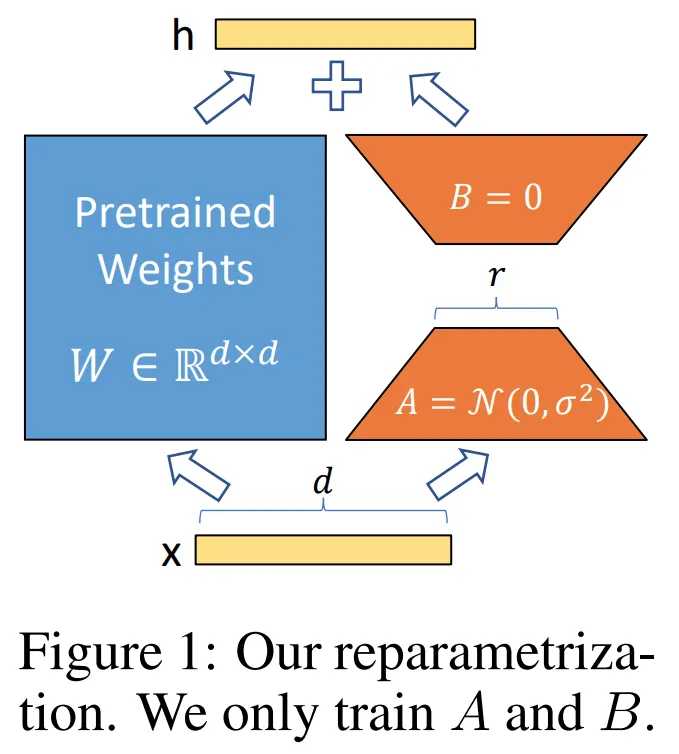

很多模型都是$y=Wx$，包含W这个线性层。LoRA的做法是不直接更新大模型参数W，而是在旁边插入一个低秩矩阵BA，作为可训练的残差项$y=Wx+BAx$ \
$ A \in \mathbb{R}^{r \times d_{\text{in}}} $
$ B \in \mathbb{R}^{d_{\text{out}} \times r} $
$ r \ll d_{\text{in}}, d_{\text{out}} $

原先微调需要更新整个$W$，其参数量为$\text{Param}(W) = d_{\text{out}} \times d_{\text{in}}$，使用LoRA后，$B A$的参数量仅为$\text{Param}{\text{LoRA}} = r \times d{\text{in}} + d_{\text{out}} \times r = r (d_{\text{in}} + d_{\text{out}})$

In [2]:
# 定义LoRA网络结构
import torch.nn as nn

class LoRA(nn.Module):
    def __init__(self, in_features, out_features, rank):
        super().__init__()
        self.rank = rank # LoRA的秩
        self.A = nn.Linear(in_features, rank, bias=False)
        self.B = nn.Linear(rank, out_features, bias=False)
        # 矩阵A高斯初始化
        # .weight是一个torch.nn.Parameter
        # .data是直接拿到底层Tensor
        # .data_normal_是原地用均值mean，标准差为std的正态分布覆盖这个tensor的所有元素
        self.A.weight.data_normal_(mean=0.0, std=0.02)
        # 矩阵B高斯初始化
        # 把整个weight矩阵全部置为0
        self.B.weight.data_normal_()
    def forward(self, x):
        return self.B(self.A(x))

# 将LoRA注入到现有LLM中

In [3]:
def apply_lora(model, rank=16):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and module.weight.shape[0] == module.weight.shape[1]:
            # 如果是nn.Linear且为方阵，则插入LoRA
            lora = LoRA(module.weight.shape[0], module.weight.shape[1], rank=rank).to(model.device)
            setattr(module, 'lora', lora) # 给module加一个lora成员变量，不改变原模型定义，让PyTorch能自动管理参【model.parameters()能找到，.to(device)会跟着,state_dict()会保存它】
            original_forward = module.forward

            # 构造新的forward: 原始输出+LoRA输出
            def forward_with_lora(x, layer1=original_forward, layer2=lora):
                return layer1(x) + layer2(x)
            
            module.forward = forward_with_lora

In [5]:
# 测试模型
class TestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1024, 1024)
    @property
    # 把model.device设为属性访问，而不是model.device()函数调用
    def device(self):
        return next(self.parameters()).device # 返回模型参数所在设备
    def forward(self, x):
        return self.linear(x)
    
model = TestModel()
print(model)

TestModel(
  (linear): Linear(in_features=1024, out_features=1024, bias=True)
)


In [6]:
apply_lora(model)
print(model)

AttributeError: 'Parameter' object has no attribute 'data_normal_'

In [ ]:
for name, module in model.named_modules():
    # named_modules是PyTorch的递归模块遍历器
    # module.__class__.__name__获取模块的类名字符串
    print(f"{name}: {module.__class__.__name__}")

## LoRA权重的加载与保存

In [ ]:
import torch

def save_lora(model, path):
    state_dict = {}
    for name, module in model.named_modules():
        if hasattr(module, "lora"):
            for k, v in module.lora.state_dict().items():
                state_dict[f"{name}.lora.{k}"] = v
    torch.save(state_dict, path)
    print(f"[LoRA] Saved {len(state_dict)} params to: {path}")

save_lora(model, "lora.pth")

In [1]:
lora = torch.load("lora.pth")
for k, v in lora.items():
    print(k, v.shape)

NameError: name 'torch' is not defined

In [ ]:
# 在加载训练好的模型权重时，只加载lora层的权重

def load_lora(model, path):
    # map_location指定加载出来的Tensor放到哪个设备上
    state_dict = torch.load(path, map_location=model.device)
    for name, module in model.named_modules():
        if hasattr(module, "lora"):
            # repalce用于隐掉{name}.lora.，因为load的执行者是module.lora,不去掉会重复
            lora_state = {k.replace(f"{name}.lora.", ''): v for k, v in state_dict.item() if f'{name}.lora.' in k}
            # 调试信息
            for k, v in lora_state.items():
                print(k, '---', v.shape)
            print(module.lora)
            module.lora.load_state_dict(lora_state)

In [ ]:
load_lora(model, "lora.pth")

## 训练LoRA

In [ ]:
# 初始化模型和分词器
model, tokenizer = init_model(lm_config)

# 注入LoRA模块
apply_lora(model)

# 计算总参数量
# .numel返回这个tensor里元素的总个数
total_params = sum(p.numel() for p in model.parameters())

# 计算所有带有lora名词的参数量
lora_params_count = sum(p.numel() for name, p in model.named_parameters() if "lora" in name)

# 只在主进程中打印参数信息
if not ddp or dist.get_rank() == 0:
    print(f"LLM总参数量：{total_params}")
    print(f"LoRA参数量: {lora_params_count}")
    print(f"LoRA参数占比: {lora_params_count / total_params * 100:.2f}%")

# 冻结除LoRA外的所有参数， 只训练LoRA层
for name, param in model.named_parameters():
    if 'lora' not in name:
        param.requires_grad = False

# 收集LoRA可训练参数
lora_params = []
for name, param in model.named_parameters():
    if 'lora' in name:
        lora_params.append(param)

# 构建优化器,仅优化LoRA参数
optimizer = optim.AdamW(lora_params, lr=args.learning_rate)

# 构建数据集，复用SFT的数据加载器
train_ds = SFTDataset(args.data_path, tokenizer, max_length=args.max_seq_len)

# 如果使用分布式训练DDP, 使用DistributedSampler划分数据
train_sampler = DistributedSampler(train_ds) if ddp else None

# 构建数据加载器
train_loader = DataLoader(
    train_ds,
    batch_size=args.batch_size,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
    num_workers=args.num_workers,
    sampler=train_sampler
)

# 使用自动混合精度AMP,加速训练，节省显存，仅当使用float16或bfloat16时启用
scaler = torch.cuda.amp.GradScaler(enabled=args.dtype in ['float16', 'bfloat16'])

# 每个epoch的迭代次数
iter_per_epoch = len(train_loader)

# 开始训练多个epoch
for epoch in range(args.epochs):
    train_epoch(epoch, wandb)